In [0]:
!git clone https://github.com/carpedm20/emoji.git

In [0]:
import os
os.chdir('/content/emoji')
!python setup.py install

In [0]:
!pip install tweet-preprocessor
!pip install wordninja

In [0]:
import numpy as np
import pandas as pd
from numpy.random import RandomState
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
from nltk.corpus import stopwords
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import  BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
import string
from nltk.stem import PorterStemmer
import wordninja
import preprocessor as p
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_learning_curves

In [0]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
df = pd.read_csv('/content/data/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv')

punct = string.punctuation
trantab = str.maketrans(punct, len(punct)*' ')
wordnet_lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words("english"))
porter = PorterStemmer()

df['text'] = df['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
df['text'] = df['text'].apply(lambda x: p.clean(str(x)).strip())
df['text'] = df['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
df['text'] = df['text'].str.strip(' "\'')
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
df['text'] = df['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
df['text'] = df['text'].apply(lambda x: ( " ".join(x)))
df['text'] = df['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
df['text'] = df['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(df.shape[0]):
  temp = []
  for word in df['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  df['text'][i] = " ".join(temp)
for i in range(df.shape[0]):
  text = df['text'][i]
  words = text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  df['text'][i]=" ".join(stemmed_words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
 x = df.iloc[:,:-1]
 y = df.iloc[:,-1:]
 x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)  # uc in future

**Naive**

In [0]:
nb_cls = Pipeline([('vect', TfidfVectorizer()),('clf', BernoulliNB())])
nb_model = nb_cls.fit(x_train.text,y_train.values.ravel())

In [0]:
predicted = nb_model.predict(x_test.text)
print(np.mean(predicted == y_test.values.ravel()))
print(f1_score(y_test.values.ravel(),predicted))

0.6574952561669829
0.7529089664613278


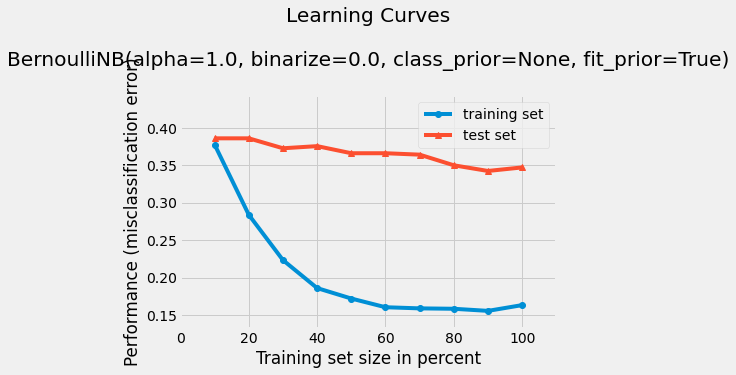

In [0]:
vect = TfidfVectorizer()
tx_train = vect.fit_transform(x_train.text)
tx_test = vect.transform(x_test.text)
bnb = BernoulliNB()
plot_learning_curves(tx_train, y_train.values.ravel(),tx_test, y_test.values.ravel(), bnb)
plt.show()

**SVM**

In [0]:
svm_linear = Pipeline([('vect', TfidfVectorizer(analyzer= 'char',ngram_range=(1,3),max_features=500000)),
                     ('clf', SVC(C=1.0, kernel='linear', degree=3, gamma='auto')),
])
linear_model = svm_linear.fit(x_train.text,y_train.values.ravel())
predicted = linear_model.predict(x_test.text)
np.mean(predicted == y_test.values.ravel())

0.6698292220113852

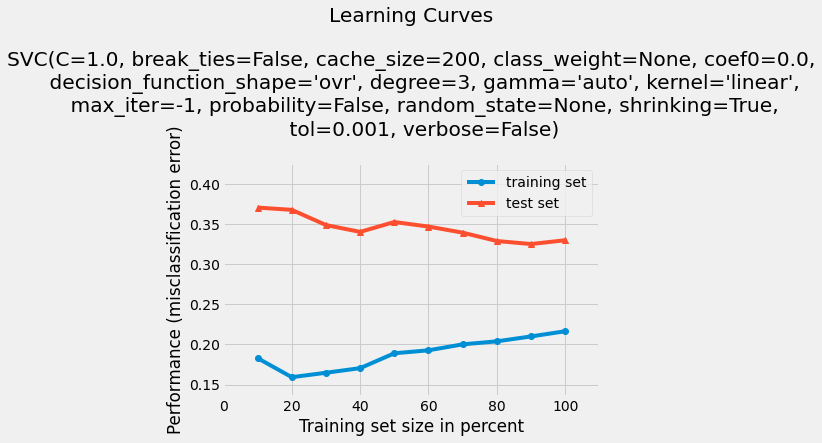

In [0]:
vect = TfidfVectorizer(analyzer= 'char',ngram_range=(1,3),max_features=500000)
tx_train = vect.fit_transform(x_train.text)
tx_test = vect.transform(x_test.text)
svc_linear =  SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
plot_learning_curves(tx_train, y_train.values.ravel(),tx_test, y_test.values.ravel(), svc_linear)
plt.show()

In [0]:
svm_poly = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC(kernel='poly')),
])
poly_model = svm_poly.fit(x_train.text,y_train.values.ravel())
predicted = poly_model.predict(x_test.text)
np.mean(predicted == y_test.values.ravel())

0.6214421252371917

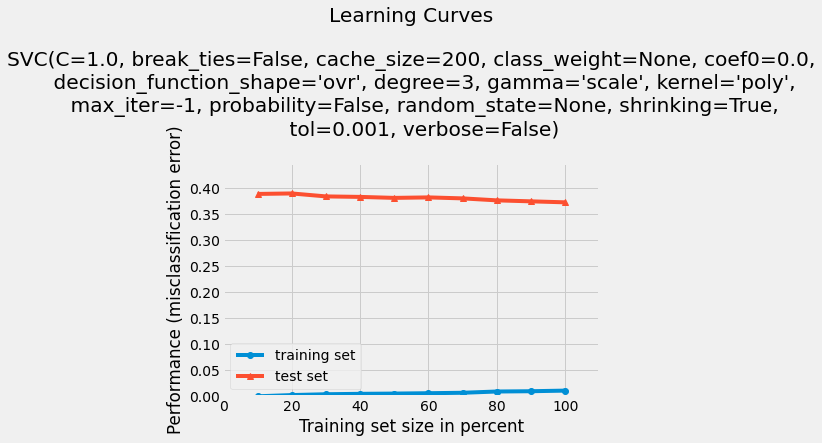

In [0]:
vect = TfidfVectorizer()
tx_train = vect.fit_transform(x_train.text)
tx_test = vect.transform(x_test.text)
svc_poly =  SVC(kernel='poly')
plot_learning_curves(tx_train, y_train.values.ravel(),tx_test, y_test.values.ravel(), svc_poly)
plt.show()

In [0]:
svm_rbf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf',C=1.0)),
])
rbf_model = svm_rbf.fit(x_train.text,y_train.values.ravel())
predicted = rbf_model.predict(x_test.text)
np.mean(predicted == y_test.values.ravel())

0.6631878557874763

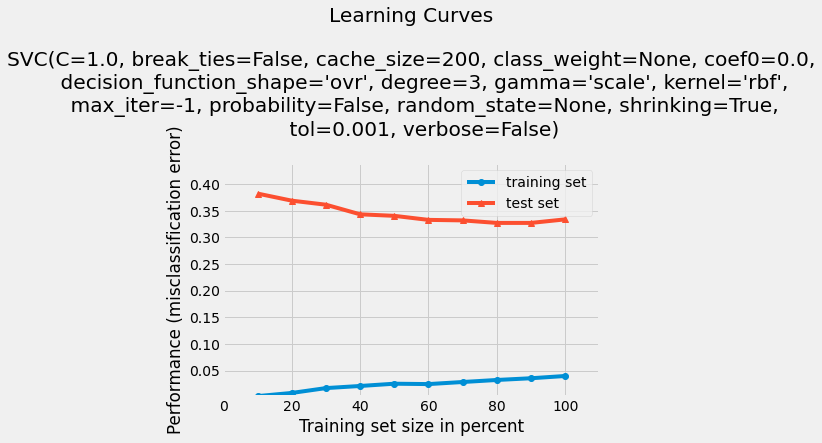

In [0]:
vect = TfidfVectorizer()
tx_train = vect.fit_transform(x_train.text)
tx_test = vect.transform(x_test.text)
svc_rbf =  SVC(kernel='rbf',C=1.0)
plot_learning_curves(tx_train, y_train.values.ravel(),tx_test, y_test.values.ravel(), svc_rbf)
plt.show()

**Logistic Regression**

In [0]:
logreg = Pipeline([('vect', TfidfVectorizer(analyzer= 'char',ngram_range=(1,20),max_features=500000, norm='l2')),
                ('clf', LogisticRegression(random_state=0)),
               ])
logreg.fit(x_train.text, y_train.values.ravel())
y_pred = logreg.predict(x_test.text)
print(np.mean(y_test.values.ravel() == y_pred))
print(f1_score(y_test.values.ravel(),y_pred))

0.6764705882352942
0.7665982203969884


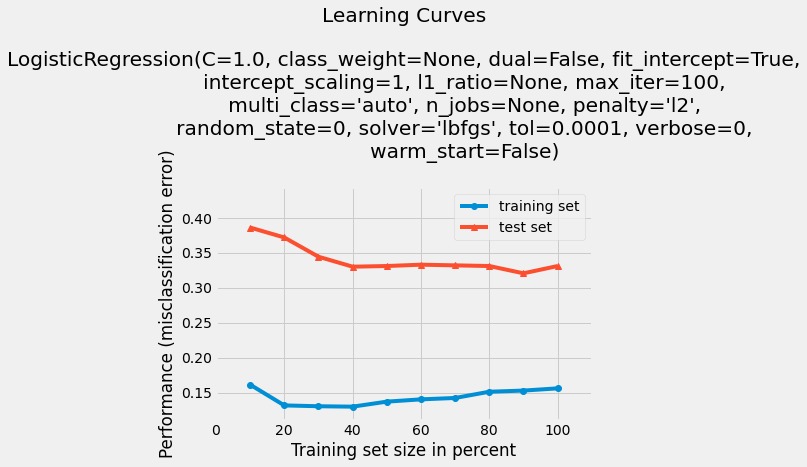

In [0]:
vect = TfidfVectorizer(analyzer= 'char',ngram_range=(1,20),max_features=500000, norm='l2')
tx_train = vect.fit_transform(x_train.text)
tx_test = vect.transform(x_test.text)
lr =  LogisticRegression(random_state=0)
plot_learning_curves(tx_train, y_train.values.ravel(),tx_test, y_test.values.ravel(), lr)
plt.show()

**Final**

In [0]:
logregf = Pipeline([('vect', TfidfVectorizer(analyzer= 'char',ngram_range=(1,20),max_features=500000)),
                ('clf', LogisticRegression(random_state=0)),
               ])
logregf.fit(x.text, y.values.ravel())
y_pred = logregf.predict(x_t.text)
import csv

filename="submission.csv"
with open(filename, "wb") as f:
    f.write(b'labels\n')
    np.savetxt(f, y_pred.astype(int), fmt='%i', delimiter=",")

**Neural Nets**

In [0]:
vect = TfidfVectorizer()
x_train_nn = vect.fit_transform(x_train.text.ravel())
x_test_nn = vect.transform(x_test.text.ravel())

In [0]:
nn1 = Sequential()
nn1.add(Dense(10, activation='relu', input_dim = x_train_nn.shape[1]))
nn1.add(Dense(1,activation='sigmoid'))
nn1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn1.fit(x_train_nn, y_train, epochs=10, verbose=1)

Epoch 1/10
4212/4212 [==============================] - 1s 222us/step - loss: 0.6766 - accuracy: 0.6097
Epoch 2/10
4212/4212 [==============================] - 1s 156us/step - loss: 0.6339 - accuracy: 0.6239
Epoch 3/10
4212/4212 [==============================] - 1s 153us/step - loss: 0.5686 - accuracy: 0.7305
Epoch 4/10
4212/4212 [==============================] - 1s 157us/step - loss: 0.4955 - accuracy: 0.8274
Epoch 5/10
4212/4212 [==============================] - 1s 154us/step - loss: 0.4277 - accuracy: 0.8621
Epoch 6/10
4212/4212 [==============================] - 1s 155us/step - loss: 0.3709 - accuracy: 0.8896
Epoch 7/10
4212/4212 [==============================] - 1s 156us/step - loss: 0.3221 - accuracy: 0.9091
Epoch 8/10
4212/4212 [==============================] - 1s 153us/step - loss: 0.2820 - accuracy: 0.9224
Epoch 9/10
4212/4212 [==============================] - 1s 162us/step - loss: 0.2486 - accuracy: 0.9330
Epoch 10/10
4212/4212 [==============================] - 1s 152u

In [0]:
loss, acc = nn1.evaluate(x_test_nn, y_test, verbose=0) 
acc

0.6290322542190552

Epoch 1/1
421/421 [==============================] - 0s 218us/step - loss: 0.1979 - accuracy: 0.9715
Epoch 1/1
842/842 [==============================] - 0s 207us/step - loss: 0.1859 - accuracy: 0.9656
Epoch 1/1
1263/1263 [==============================] - 0s 202us/step - loss: 0.1769 - accuracy: 0.9644
Epoch 1/1
1684/1684 [==============================] - 0s 208us/step - loss: 0.1611 - accuracy: 0.9685
Epoch 1/1
2106/2106 [==============================] - 0s 198us/step - loss: 0.1546 - accuracy: 0.9720
Epoch 1/1
2527/2527 [==============================] - 1s 201us/step - loss: 0.1464 - accuracy: 0.9695
Epoch 1/1
2948/2948 [==============================] - 1s 204us/step - loss: 0.1381 - accuracy: 0.9712
Epoch 1/1
3369/3369 [==============================] - 1s 208us/step - loss: 0.1331 - accuracy: 0.9688
Epoch 1/1
3790/3790 [==============================] - 1s 212us/step - loss: 0.1323 - accuracy: 0.9633
Epoch 1/1
4212/4212 [==============================] - 1s 207us/step - loss: 

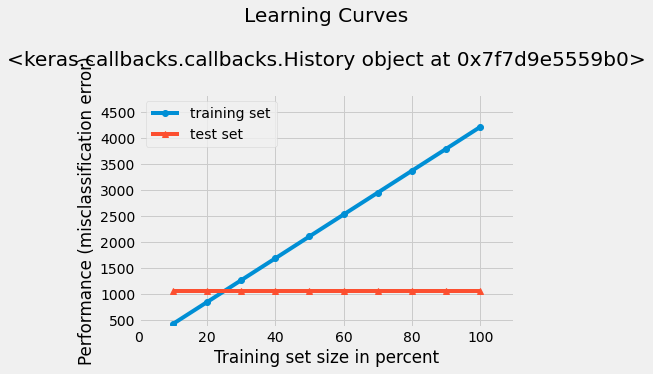

In [0]:
vect = TfidfVectorizer()
tx_train = vect.fit_transform(x_train.text)
tx_test = vect.transform(x_test.text)
plot_learning_curves(tx_train, y_train.values.ravel(),tx_test, y_test.values.ravel(), nn1)
plt.show()

**Random forest**

In [0]:
vect = TfidfVectorizer(analyzer= 'char',ngram_range=(1,20),max_features=500000)
x_train_rf = vect.fit_transform(x_train.text.ravel())
x_test_rf = vect.transform(x_test.text.ravel())

In [0]:
classifier = RandomForestClassifier(n_estimators=2000, random_state=0)
classifier.fit(x_train_rf, y_train.values.ravel())
y_pred = classifier.predict(x_test_rf)
np.mean(y_pred == y_test.values.ravel())
print(f1_score(y_test.values.ravel(),y_pred))

0.7574291637871459


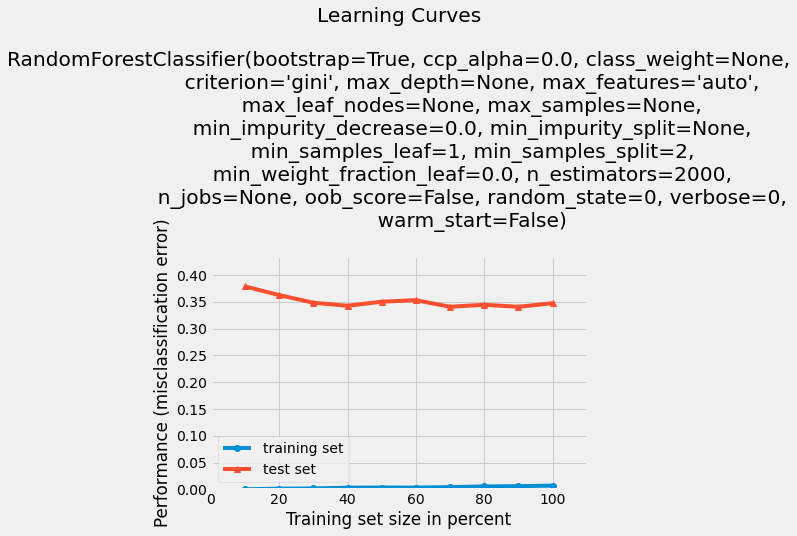

In [0]:
vect = TfidfVectorizer(analyzer= 'char',ngram_range=(1,20),max_features=500000)
tx_train = vect.fit_transform(x_train.text)
tx_test = vect.transform(x_test.text)
rf =  RandomForestClassifier(n_estimators=2000, random_state=0)
plot_learning_curves(tx_train, y_train.values.ravel(),tx_test, y_test.values.ravel(), rf)
plt.show()

**LSTM**

In [0]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(x_train.text)
word_index = tokenizer.word_index

In [0]:
x_train_lstm = tokenizer.texts_to_sequences(x_train.text)
x_test_lstm = tokenizer.texts_to_sequences(x_test.text)
x_train_lstm = pad_sequences(x_train_lstm, maxlen=MAX_SEQUENCE_LENGTH)
x_test_lstm = pad_sequences(x_test_lstm, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x_train_lstm.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
history = model.fit(x_train_lstm, y_train, epochs=epochs)
loss, accuracy = model.evaluate(x_test_lstm, y_test, verbose=False)
accuracy

In [0]:
plot_learning_curves(x_train_lstm, y_train.values.ravel(),x_test_lstm, y_test.values.ravel(), model)
plt.show()

**New Model**

In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [0]:
vect = TfidfVectorizer(analyzer= 'char',ngram_range=(1,20),max_features=500000)
x_train_nm = vect.fit_transform(x_train.text.ravel())
x_test_nm = vect.transform(x_test.text.ravel())

In [0]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l2",C=0.01))
X_ = select.fit_transform(x_train_nm,y_train.values.ravel())
X_t = select.transform(x_test_nm)

In [0]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_, y_train.values.ravel())

In [0]:
y_pred = model.predict(X_t)
np.mean(y_pred == y_test.values.ravel())

0.6043643263757116

In [0]:
!pip install wordninja

In [0]:
df = pd.read_csv('/content/data/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv')
tdf = df.copy()
df['text'] = df['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
df['text'] = df['text'].apply(lambda x: p.clean(str(x)).strip())
df['text'] = df['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
df['text'] = df['text'].str.strip(' "\'')
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
df['text'] = df['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
stops = set(stopwords.words("english"))
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
df['text'] = df['text'].apply(lambda x: ( " ".join(x)))
df['text'] = df['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
punct = string.punctuation
trantab = str.maketrans(punct, len(punct)*' ')
df['text'] = df['text'].apply(lambda x : str(x).translate(trantab).strip())
wordnet_lemmatizer = WordNetLemmatizer()
for i in range(df.shape[0]):
  temp = []
  for word in df['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  df['text'][i] = " ".join(temp)
porter = PorterStemmer()
for i in range(df.shape[0]):
  text = df['text'][i]
  words = text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  df['text'][i]=" ".join(stemmed_words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
svm_rbf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf', C= .7)),
])
rbf_model = svm_rbf.fit(x_train.text,y_train.values.ravel())
predicted = rbf_model.predict(x_test.text)
print(np.mean(predicted == y_test.values.ravel()))
print(f1_score(y_test.values.ravel(),predicted))

0.6603415559772297
0.77819083023544


<1x10516 sparse matrix of type '<class 'numpy.float64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [0]:
wordnet_lemmatizer = WordNetLemmatizer()
w = wordnet_lemmatizer.lemmatize('#AUSvIND holding Balidan badge holding', pos="v")
w = wordninja.split(str(w))
w

['A', 'USvI', 'ND', 'holding', 'Bali', 'dan', 'badge', 'holding']

**Final 2**

In [0]:
df = pd.read_csv('/content/data/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv')
tdf = pd.read_csv('/content/data/f6eb0bd7-6063-4e50-baa0-111feda638fb_test.csv')
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
df['text'] = df['text'].apply(lambda x: p.clean(str(x)).strip())
df['text'] = df['text'].apply(lambda x: str(x).lower())
df['text'] = df['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
x = df.iloc[:,:-1]
y = df.iloc[:,-1:]
x_t = tdf
svm_rbf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf')),
])
rbf_model = svm_rbf.fit(x.text,y.values.ravel())
predicted = rbf_model.predict(x_t.text)

filename="submission_final_2.csv"
with open(filename, "wb") as f:
    f.write(b'labels\n')
    np.savetxt(f, predicted.astype(int), fmt='%i', delimiter=",")

In [0]:
_

In [0]:
x = "'safer &amp; more prosperous' 😂😂😂😂😂 Oh just fuck off already, won't you? @IvankaTrump #ImpeachTrump #TrumpLiesEveryTimeHeSpeaks #TrumpIsNotAboveTheLaw #TrumpIsATraitor https://t.co/BwP41vIp2b"
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
x = p.clean(str(x)).strip()
x = wordninja.split(str(x))
# stops = set(stopwords.words("english"))
# x = [item for item in x if item not in stops and item is not ' ']
#x = " ".join(x)
x = str(x).lower()
x = re.sub(r"\b[a-zA-Z]\b", "", str(x))
punct = string.punctuation
trantab = str.maketrans(punct, len(punct)*' ')
x = str(x).translate(trantab).strip()
# wordnet_lemmatizer = WordNetLemmatizer()
# for i in range(df.shape[0]):
#   temp = []
#   for word in x.split():
#     w = wordnet_lemmatizer.lemmatize(word, pos="v")
#     temp.append(w)
#   x = " ".join(temp)
x

'safer  amp  more prosperous  oh just fuck off already  won  you   impeachtrump  trumplieseverytimehespeaks  trumpisnotabovethelaw  trumpisatraitor'

**Final 3**

In [0]:
df = pd.read_csv('/content/data/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv')
tdf = pd.read_csv('/content/data/f6eb0bd7-6063-4e50-baa0-111feda638fb_test.csv')
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
df['text'] = df['text'].apply(lambda x: p.clean(str(x)).strip())
df['text'] = df['text'].apply(lambda x: str(x).lower())
df['text'] = df['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))

tdf['text'] = tdf['text'].apply(lambda x: p.clean(str(x)).strip())
tdf['text'] = tdf['text'].apply(lambda x: str(x).lower())
tdf['text'] = tdf['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
x = df.iloc[:,:-1]
y = df.iloc[:,-1:]
x_t = tdf
svm_rbf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf')),
])
rbf_model = svm_rbf.fit(x.text,y.values.ravel())
predicted = rbf_model.predict(x_t.text)

filename="submission_final_3.csv"
with open(filename, "wb") as f:
    f.write(b'labels\n')
    np.savetxt(f, predicted.astype(int), fmt='%i', delimiter=",")

**Final 4**

In [0]:
df = pd.read_csv('/content/data/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv')
tdf = pd.read_csv('/content/data/f6eb0bd7-6063-4e50-baa0-111feda638fb_test.csv')
punct = string.punctuation
trantab = str.maketrans(punct, len(punct)*' ')
wordnet_lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words("english"))

df['text'] = df['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
df['text'] = df['text'].apply(lambda x: p.clean(str(x)).strip())
df['text'] = df['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
df['text'] = df['text'].str.strip(' "\'')
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
df['text'] = df['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
df['text'] = df['text'].apply(lambda x: ( " ".join(x)))
df['text'] = df['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
df['text'] = df['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(df.shape[0]):
  temp = []
  for word in df['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  df['text'][i] = " ".join(temp)


tdf['text'] = tdf['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
tdf['text'] = tdf['text'].apply(lambda x: p.clean(str(x)).strip())
tdf['text'] = tdf['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
tdf['text'] = tdf['text'].str.strip(' "\'')
tdf['text'] = tdf['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
tdf['text'] = tdf['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
tdf['text'] = tdf['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
tdf['text'] = tdf['text'].apply(lambda x: ( " ".join(x)))
tdf['text'] = tdf['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
tdf['text'] = tdf['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(tdf.shape[0]):
  temp = []
  for word in tdf['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  tdf['text'][i] = " ".join(temp)

x = df.iloc[:,:-1]
y = df.iloc[:,-1:]
x_t = tdf
svm_rbf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf', C=1.0)),
])
rbf_model = svm_rbf.fit(x.text,y.values.ravel())
predicted = rbf_model.predict(x_t.text)

filename="submission_final_4.csv"
with open(filename, "wb") as f:
    f.write(b'labels\n')
    np.savetxt(f, predicted.astype(int), fmt='%i', delimiter=",")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**FInal 5**

In [0]:
df = pd.read_csv('/content/data/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv')
tdf = pd.read_csv('/content/data/f6eb0bd7-6063-4e50-baa0-111feda638fb_test.csv')
punct = string.punctuation
trantab = str.maketrans(punct, len(punct)*' ')
wordnet_lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words("english"))

df['text'] = df['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
df['text'] = df['text'].apply(lambda x: p.clean(str(x)).strip())
df['text'] = df['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
df['text'] = df['text'].str.strip(' "\'')
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
df['text'] = df['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
# df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
df['text'] = df['text'].apply(lambda x: ( " ".join(x)))
df['text'] = df['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
# df['text'] = df['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(df.shape[0]):
  temp = []
  for word in df['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  df['text'][i] = " ".join(temp)


tdf['text'] = tdf['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
tdf['text'] = tdf['text'].apply(lambda x: p.clean(str(x)).strip())
tdf['text'] = tdf['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
tdf['text'] = tdf['text'].str.strip(' "\'')
tdf['text'] = tdf['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
tdf['text'] = tdf['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
# tdf['text'] = tdf['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
tdf['text'] = tdf['text'].apply(lambda x: ( " ".join(x)))
tdf['text'] = tdf['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
# tdf['text'] = tdf['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(tdf.shape[0]):
  temp = []
  for word in tdf['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  tdf['text'][i] = " ".join(temp)

x = df.iloc[:,:-1]
y = df.iloc[:,-1:]
x_t = tdf
svm_rbf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf', C=1.0)),
])
rbf_model = svm_rbf.fit(x.text,y.values.ravel())
predicted = rbf_model.predict(x_t.text)

filename="submission_final_5.csv"
with open(filename, "wb") as f:
    f.write(b'labels\n')
    np.savetxt(f, predicted.astype(int), fmt='%i', delimiter=",")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Final 6**

In [0]:
df = pd.read_csv('/content/data/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv')
tdf = pd.read_csv('/content/data/f6eb0bd7-6063-4e50-baa0-111feda638fb_test.csv')
punct = string.punctuation
trantab = str.maketrans(punct, len(punct)*' ')
wordnet_lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words("english"))
porter = PorterStemmer()

df['text'] = df['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
df['text'] = df['text'].apply(lambda x: p.clean(str(x)).strip())
df['text'] = df['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
df['text'] = df['text'].str.strip(' "\'')
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
df['text'] = df['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
df['text'] = df['text'].apply(lambda x: ( " ".join(x)))
df['text'] = df['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
df['text'] = df['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(df.shape[0]):
  temp = []
  for word in df['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  df['text'][i] = " ".join(temp)
for i in range(df.shape[0]):
  text = df['text'][i]
  words = text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  df['text'][i]=" ".join(stemmed_words)


tdf['text'] = tdf['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
tdf['text'] = tdf['text'].apply(lambda x: p.clean(str(x)).strip())
tdf['text'] = tdf['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
tdf['text'] = tdf['text'].str.strip(' "\'')
tdf['text'] = tdf['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
tdf['text'] = tdf['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
tdf['text'] = tdf['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
tdf['text'] = tdf['text'].apply(lambda x: ( " ".join(x)))
tdf['text'] = tdf['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
tdf['text'] = tdf['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(tdf.shape[0]):
  temp = []
  for word in tdf['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  tdf['text'][i] = " ".join(temp)
for i in range(tdf.shape[0]):
  text = tdf['text'][i]
  words = text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  tdf['text'][i]=" ".join(stemmed_words)


x = df.iloc[:,:-1]
y = df.iloc[:,-1:]
x_t = tdf
svm_rbf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf', C=1.0)),
])
rbf_model = svm_rbf.fit(x.text,y.values.ravel())
predicted = rbf_model.predict(x_t.text)

filename="submission_final_6.csv"
with open(filename, "wb") as f:
    f.write(b'labels\n')
    np.savetxt(f, predicted.astype(int), fmt='%i', delimiter=",")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Final 7**

In [0]:
df = pd.read_csv('/content/data/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv')
tdf = pd.read_csv('/content/data/f6eb0bd7-6063-4e50-baa0-111feda638fb_test.csv')
punct = string.punctuation
trantab = str.maketrans(punct, len(punct)*' ')
wordnet_lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words("english"))
porter = PorterStemmer()

df['text'] = df['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
df['text'] = df['text'].apply(lambda x: p.clean(str(x)).strip())
df['text'] = df['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
df['text'] = df['text'].str.strip(' "\'')
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
df['text'] = df['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
df['text'] = df['text'].apply(lambda x: ( " ".join(x)))
df['text'] = df['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
df['text'] = df['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(df.shape[0]):
  temp = []
  for word in df['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  df['text'][i] = " ".join(temp)
for i in range(df.shape[0]):
  text = df['text'][i]
  words = text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  df['text'][i]=" ".join(stemmed_words)


tdf['text'] = tdf['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
tdf['text'] = tdf['text'].apply(lambda x: p.clean(str(x)).strip())
tdf['text'] = tdf['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
tdf['text'] = tdf['text'].str.strip(' "\'')
tdf['text'] = tdf['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
tdf['text'] = tdf['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
tdf['text'] = tdf['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
tdf['text'] = tdf['text'].apply(lambda x: ( " ".join(x)))
tdf['text'] = tdf['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
tdf['text'] = tdf['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(tdf.shape[0]):
  temp = []
  for word in tdf['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  tdf['text'][i] = " ".join(temp)
for i in range(tdf.shape[0]):
  text = tdf['text'][i]
  words = text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  tdf['text'][i]=" ".join(stemmed_words)


x = df.iloc[:,:-1]
y = df.iloc[:,-1:]
x_t = tdf
svm_rbf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf', C=.7)),
])
rbf_model = svm_rbf.fit(x.text,y.values.ravel())
predicted = rbf_model.predict(x_t.text)

filename="submission_final_7.csv"
with open(filename, "wb") as f:
    f.write(b'labels\n')
    np.savetxt(f, predicted.astype(int), fmt='%i', delimiter=",")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Hate speech detection**

In [0]:
import numpy as np
import pandas as pd
from numpy.random import RandomState
from collections import Counter
from nltk.corpus import stopwords
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import string
from nltk.stem import PorterStemmer
import wordninja
import preprocessor as p
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('/content/data/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv')
tdf = pd.read_csv('/content/final_test_q1/fcac6286-6db1-4577-ad80-612fb9d36db9_test.csv')

punct = string.punctuation
trantab = str.maketrans(punct, len(punct)*' ')
wordnet_lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words("english"))
porter = PorterStemmer()

df['text'] = df['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
df['text'] = df['text'].apply(lambda x: p.clean(str(x)).strip())
df['text'] = df['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
df['text'] = df['text'].str.strip(' "\'')
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
df['text'] = df['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
df['text'] = df['text'].apply(lambda x: ( " ".join(x)))
df['text'] = df['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
df['text'] = df['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(df.shape[0]):
  temp = []
  for word in df['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  df['text'][i] = " ".join(temp)
for i in range(df.shape[0]):
  text = df['text'][i]
  words = text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  df['text'][i]=" ".join(stemmed_words)


tdf['text'] = tdf['text'].apply(lambda x: str(x).lower())
p.set_options(p.OPT.URL,p.OPT.EMOJI,p.OPT.MENTION,p.OPT.NUMBER)
tdf['text'] = tdf['text'].apply(lambda x: p.clean(str(x)).strip())
tdf['text'] = tdf['text'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', str(x)))
tdf['text'] = tdf['text'].str.strip(' "\'')
tdf['text'] = tdf['text'].apply(lambda x: re.sub(r'\s+', ' ', str(x)))
tdf['text'] = tdf['text'].apply(lambda x : str(x).split())#wordninja.split(str(x))) #str(x).split())
tdf['text'] = tdf['text'].apply(lambda x: [item for item in x if item not in stops and item is not ' '])
tdf['text'] = tdf['text'].apply(lambda x: ( " ".join(x)))
tdf['text'] = tdf['text'].apply(lambda x : re.sub(r"\b[a-zA-Z]\b", "", str(x)))
tdf['text'] = tdf['text'].apply(lambda x : str(x).translate(trantab).strip())
for i in range(tdf.shape[0]):
  temp = []
  for word in tdf['text'][i].split():
    w = wordnet_lemmatizer.lemmatize(word)
    temp.append(w)
  tdf['text'][i] = " ".join(temp)
for i in range(tdf.shape[0]):
  text = tdf['text'][i]
  words = text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  tdf['text'][i]=" ".join(stemmed_words)


x = df.iloc[:,:-1]
y = df.iloc[:,-1:]
x_t = tdf
svm_rbf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', SVC(kernel='rbf', C=1.0)),
])
rbf_model = svm_rbf.fit(x.text,y.values.ravel())
predicted = rbf_model.predict(x_t.text)

pred_df = pd.DataFrame({'labels':predicted})
pred_df.to_csv('submission.csv',index=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to b